# Twitter Sentiment Analysis
Twitter is one of the fastest-moving social media platforms in the world, where users freely express their opinions about various entities, from technology companies and digital products to public figures. These opinions can represent broader public perception. Analyzing these opinions is crucial for companies, researchers, and data analysts to understand trends, measure reputation, and develop data-driven strategies.

This project focuses on sentiment analysis of Twitter tweets about various entities, such as Facebook, Amazon, Microsoft, CS-GO, and Google. The data used includes tweet IDs, entity names, sentiment categories, and tweet text content. The analysis is conducted through a series of stages, starting with cleaning and text preprocessing, exploring the distribution of sentiment per entity, and calculating the net score and sentiment proportion.

In the modeling phase, this project comprehensively tests various machine learning algorithms, including KNN models, decision trees, logistic regression, and others, to compare performance and identify the best model for predicting sentiment. This approach not only generates descriptive insights through exploratory data analysis (EDA) but also builds a sentiment prediction system that can be applied to new data.

With a combination of descriptive analysis, interactive visualization, and predictive model evaluation, this project is expected to serve as a portfolio example that demonstrates technical capabilities in Natural Language Processing (NLP), data analysis, and the end-to-end application of various machine learning algorithms.

# Import Library

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Data Loading
The process begins by loading a Twitter dataset containing tweet text and its sentiment labels. The dataset is read using a Python library like pandas, making it easier to explore and manipulate the data in the next stage.

In [ ]:
col_names=["tweet id","entity","sentiment","tweet content"]
df = pd.read_excel("C:/Users/LENOVO/Python/twitter_training.xlsx",names=col_names,header=None)
df.head()

,tweet id,entity,sentiment,tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
df_val = pd.read_csv("twitter_validation.csv",names=col_names,header=None)
df_val.head()

,tweet id,entity,sentiment,tweet content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


# Data Cleaning

## Removing null values
Data containing empty or unfilled values is removed to prevent disruption to the analysis process. This is important to maintain dataset integrity and prevent errors in subsequent processing stages.

Before cleaning

In [ ]:
df.isnull().sum()

,0
tweet id,0
entity,0
sentiment,0
tweet content,858


After cleaning

In [ ]:
df = df.dropna()
df.isnull().sum()

,0
tweet id,0
entity,0
sentiment,0
tweet content,0


## Removing duplicate values
Identical tweets are detected and removed to avoid bias due to repetition of the same data.

In [ ]:
Before cleaning

In [ ]:
df_duplicated = df.duplicated().sum()
print(f"There are {df_duplicated} duplicate values in the dataset")

Ada 2691 nilai duplikat dalam dataset


In [ ]:
After cleaning

In [ ]:
df = df.drop_duplicates()
df_remove_duplicated = df.duplicated().sum()
print(f"There are {df_remove_duplicated} duplicate values in the dataset")

Ada 0 nilai duplikat dalam dataset


## Removing Values Other Than Strings
Some entries may contain numeric values or data types other than strings. These rows are removed to ensure all data can be processed by text analysis methods.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71133 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet id       71133 non-null  int64 
 1   entity         71133 non-null  object
 2   sentiment      71133 non-null  object
 3   tweet content  71133 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


In [ ]:
df["tweet content"].apply(type).value_counts()

,count
tweet content,
<class 'str'>,71127
<class 'int'>,5
<class 'datetime.datetime'>,1


In [ ]:
non_str_count = df["tweet content"].apply(lambda x: not isinstance(x, str)).sum() #Check if the object data type is
print(f"There are {non_str_count} values that are not strings in the tweet content column.")

Ada 6 nilai yang bukan string di kolom tweet content.


In [ ]:
non_string_rows = df[~df["tweet content"].apply(lambda x: isinstance(x, str))] #Check if the object data type is
print(non_string_rows)

       tweet id                entity sentiment        tweet content
21509      4081                 CS-GO  Positive                    2
35855      8155             Microsoft   Neutral                    2
39519      5583           Hearthstone   Neutral  2024-04-06 00:00:00
49499      6097                  FIFA  Negative                    2
63768      7728             MaddenNFL   Neutral                    2
70571     10889  TomClancysGhostRecon  Negative                    8


Since it has nothing to do with the tweet and the sentiment is strange, it will be deleted.

In [ ]:
df = df[df["tweet content"].apply(lambda x: isinstance(x, str))]
df = df.reset_index(drop=True)
df["tweet content"].apply(type).value_counts()

,count
tweet content,
<class 'str'>,71127


## Removing outliers
Identifying outliers in tweet content length
Data that deviates statistically significantly from the majority is identified as an outlier. Outliers can arise from text that is either too short or too long.

[Text(0.5, 1.0, 'Distribution of tweet content length')]

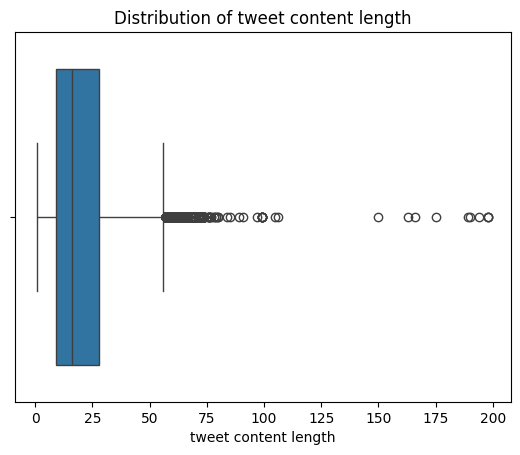

In [ ]:
#df["tweet content"] = df["tweet content"].astype(str) #Tanpa ini, ada baris yang dianggap sebagai integer
df["tweet content length"] = df["tweet content"].map(lambda x:len(x.split(" ")))
sns.boxplot(x="tweet content length",data=df).set(title='Distribution of tweet content length')

* Main Range of Tweet Length
    * The majority of tweets are between approximately 5 and 50 words long.
    * This is indicated by the length of the box (interquartile range / IQR), which is from the 1st quartile (Q1) to the 3rd quartile (Q3).
    * The median (horizontal line inside the box) is near the bottom of the box, indicating a slightly right-skewed distribution.
* Outliers
    * Some tweets even reach lengths of more than 150 words, which is very rare in typical tweets.
    * This could be due to threads or the combination of several sentences. It could also be spam, advertising, or input errors (paragraphs entered as tweets).
* Positively Skewed Distribution (skewed to the right), meaning most tweets are short and few are very long.

### Using IQR (interquartile range) to remove outlier rows
The Interquartile Range (IQR) method is used to detect and remove outliers based on the distribution of text lengths. This approach helps maintain representative and consistent data.

In [ ]:
lower_quartile = np.percentile(df["tweet content length"],25) #Calculating the 1st quartile
median = np.percentile(df["tweet content length"],50) #Calculating the median
upper_quartile = np.percentile(df["tweet content length"],75) #Menghitung quartil 3

interquartile_range = upper_quartile - lower_quartile #Calculating the interquartile_range(IQR)
lower_boundary = lower_quartile - 1.5*interquartile_range #Calculating the lower boundary
upper_boundary = upper_quartile + 1.5*interquartile_range #Calculating the upper boundary

#Twitter content length greater than the upper boundary or less than the lower_boundary will be deleted.
print("lower_boundary:",lower_boundary)
print("upper_boundary:",upper_boundary)

lower_boundary: -19.5
upper_boundary: 56.5


* Tweets with a length of > 56.5 words are considered outliers.
* Tweets with a length of < -19.5 words are unlikely to occur as this is a negative value and will be practically ignored, as word length cannot be negative.

Removing outliers

In [ ]:
removed_df = df[(df["tweet content length"]>=lower_boundary)&(df["tweet content length"]<=upper_boundary)]

Comparing the distribution of tweet content length before and after outlier removal

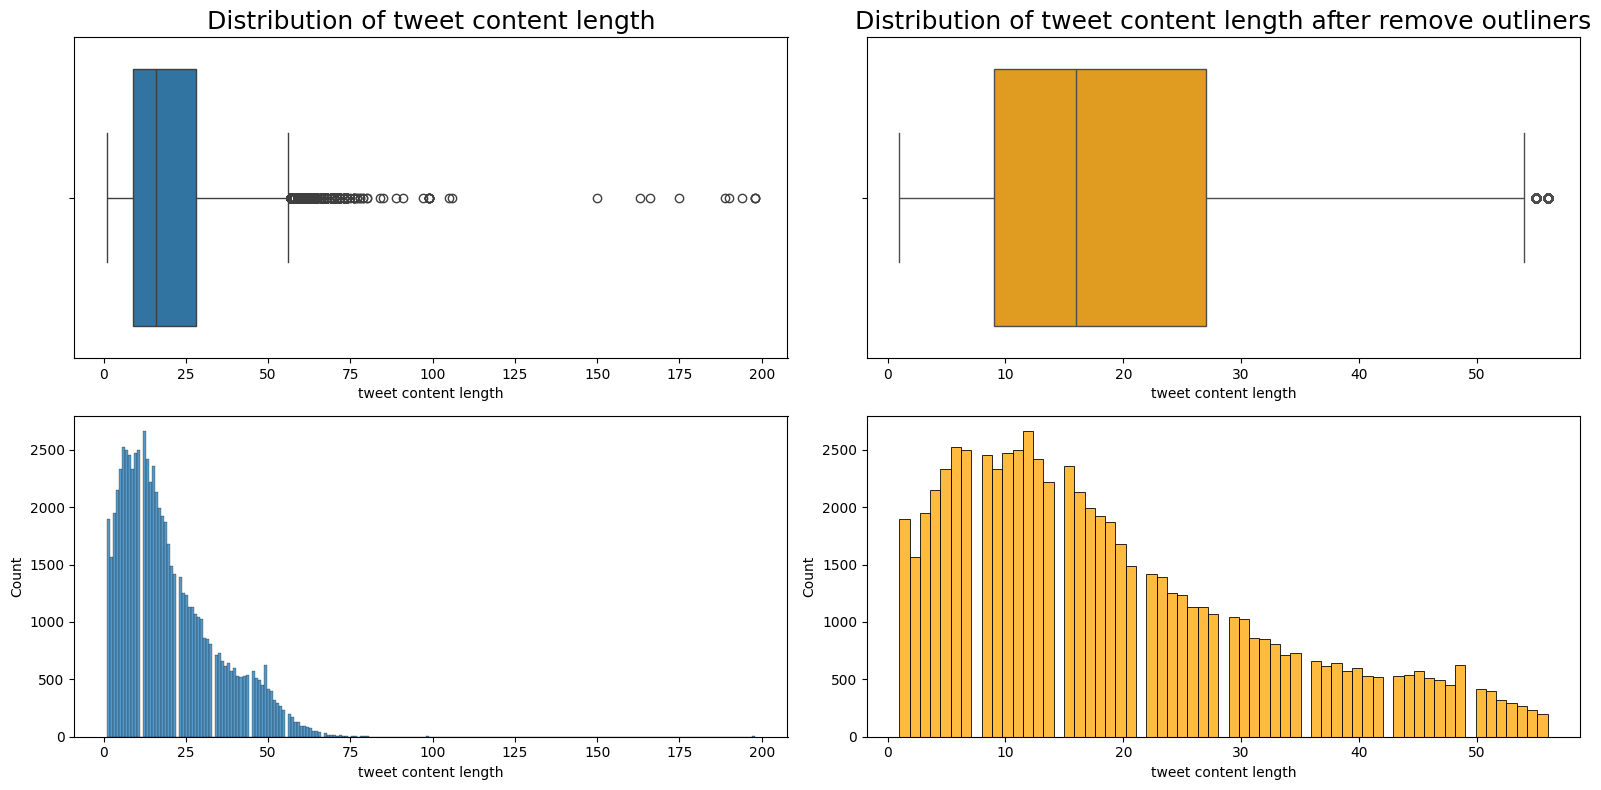

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))

#Distribution of tweet content length
sns.boxplot(x="tweet content length",data=df,ax=ax[0,0]).set_title("Distribution of tweet content length",fontsize=18)
sns.boxplot(x="tweet content length",data=removed_df,ax=ax[0,1],color="orange").set_title("Distribution of tweet content length after remove outliners",fontsize=18)

#frequency of tweet content length
sns.histplot(x="tweet content length",data=df,ax=ax[1,0])
sns.histplot(x="tweet content length",data=removed_df,ax=ax[1,1],color="orange")

fig.tight_layout()

### Interpretation Before Removing Outliers (LEFT)
* Boxplot
    * Most tweets are under 50 words in length.
    * There are many very long outliers (>100 words, even approaching 200).
    * The median is around 20 words.
    * The distribution is strongly skewed to the right (positively skewed).
* Histogram
    * The majority of tweets are short, with the peak number of tweets around 10–25 words.
    * The long tail to the right indicates the presence of some very long, but rare, tweets.
### Interpretation After Removing Outliers (RIGHT)
* Boxplot
    * Almost no outliers (because they have been removed).
    * The remaining tweet length ranges from 0–56 words (based on the upper boundary of the IQR).
    * The median remains around 20, but the distribution is more compact and cleaner.
* Histogram
    * The distribution looks clearer.
    * The majority of tweets are in the 10–25 word range.
    * The distribution remains skewed to the right, but is more symmetrical and less extreme.
    * There is no interference from extreme values as before.

The tendency for tweet content length to decrease after removing outliers, meaning that tweet content has a more even distribution.

## Label Distribution after Data Cleaning
After the cleaning process, the sentiment label distribution was reanalyzed to ensure data balance and identify possible class imbalances.

<Axes: xlabel='sentiment', ylabel='count'>

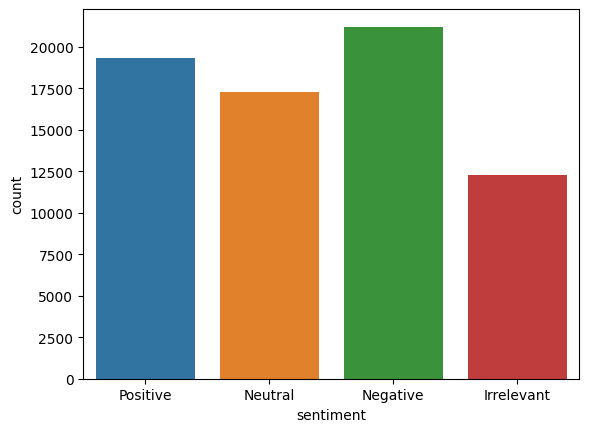

In [ ]:
sns.countplot(x="sentiment", data=removed_df, hue="sentiment")

The sentiment distribution is balanced, therefore resampling is not necessary.

# Exploratory Data Analysis
EDA is conducted to understand data patterns through visualization and descriptive statistics. This stage helps uncover initial insights before moving on to the modeling phase.

## Frequency of words (wordcloud)
The WordCloud visualization was created to display the most frequently occurring words in a dataset. WordCloud helps provide an intuitive overview of the dominant topics discussed.

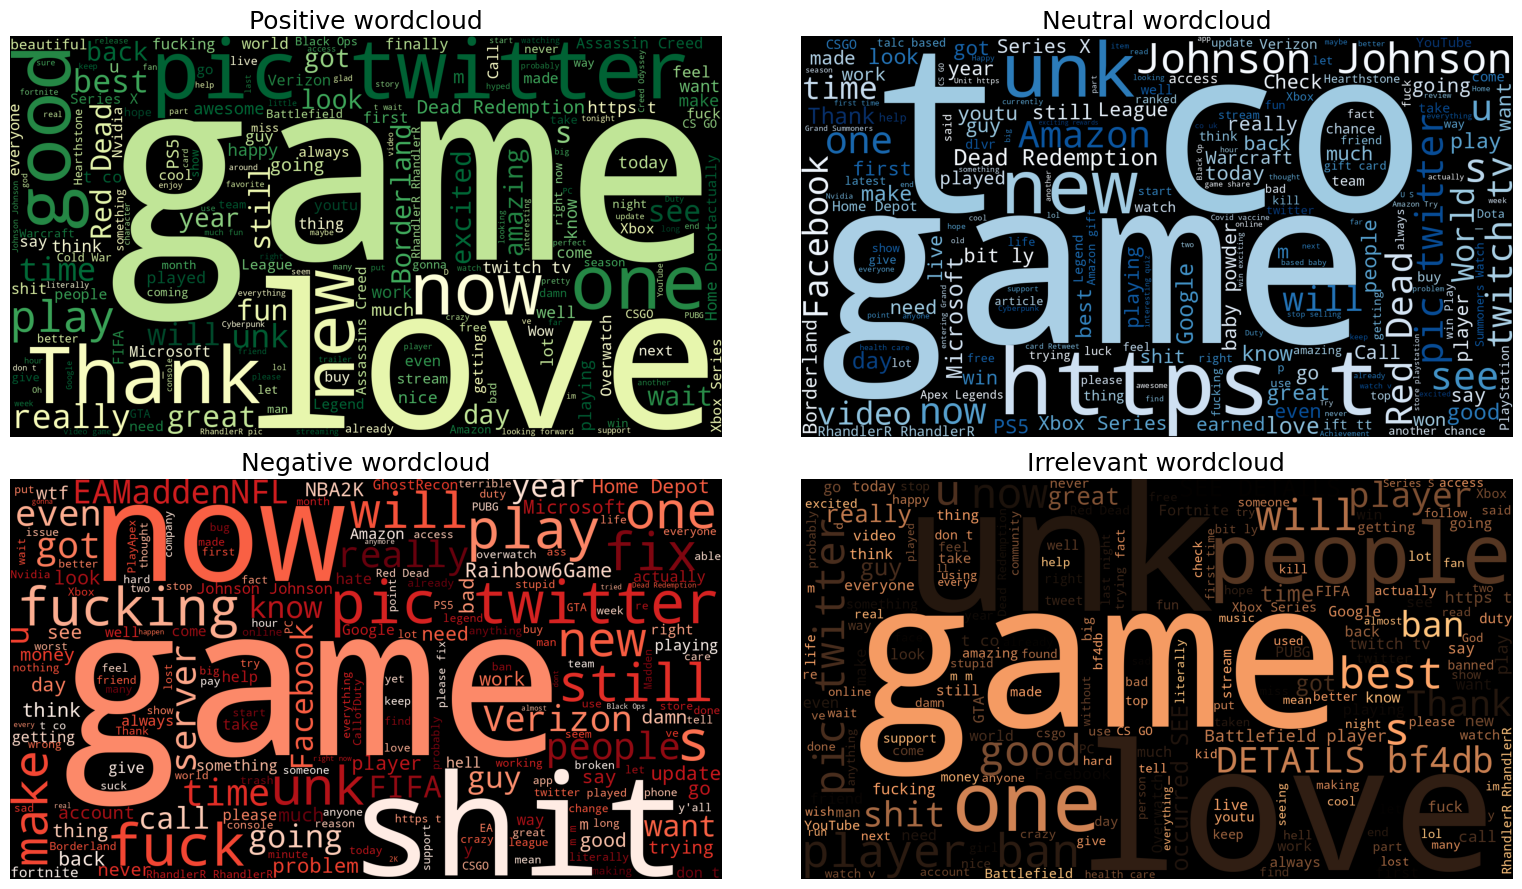

In [ ]:
sentiment_list=["Positive","Neutral","Negative","Irrelevant"]
colormap_list=["YlGn_r","Blues_r","Reds_r","copper_r"]
ax_list = [[0,0],[0,1],[1,0],[1,1]]

#Creates a set of stopwords (common words like “the”, “and”, “is”, etc.)
#from the WordCloud library that will be ignored in the visualization.
stopwords_set = set(STOPWORDS)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,9))
for sentiment,(row,col),colormap in zip(sentiment_list,ax_list,colormap_list): #Perform simultaneous iterations

    #Create a wordcloud for each sentiment
    text = " ".join(content for content in removed_df[removed_df["sentiment"]==sentiment]["tweet content"])
    #.generate(text): generates a word cloud from the combined text.
    wordcloud = WordCloud(colormap=colormap, stopwords=stopwords_set, width=1600, height=900).generate(text)

    #Plotting wordcloud
    ax[row,col].imshow(wordcloud)
    ax[row,col].set_title(sentiment+" wordcloud", fontsize=18)
    ax[row,col].axis('off')

fig.tight_layout()

## Frequency of Entity
Analysis is performed to determine how frequently a particular entity appears in a dataset. An entity can be a brand name, a figure, or a specific topic.

Text(0.5, 1.0, 'Frequency of entity')

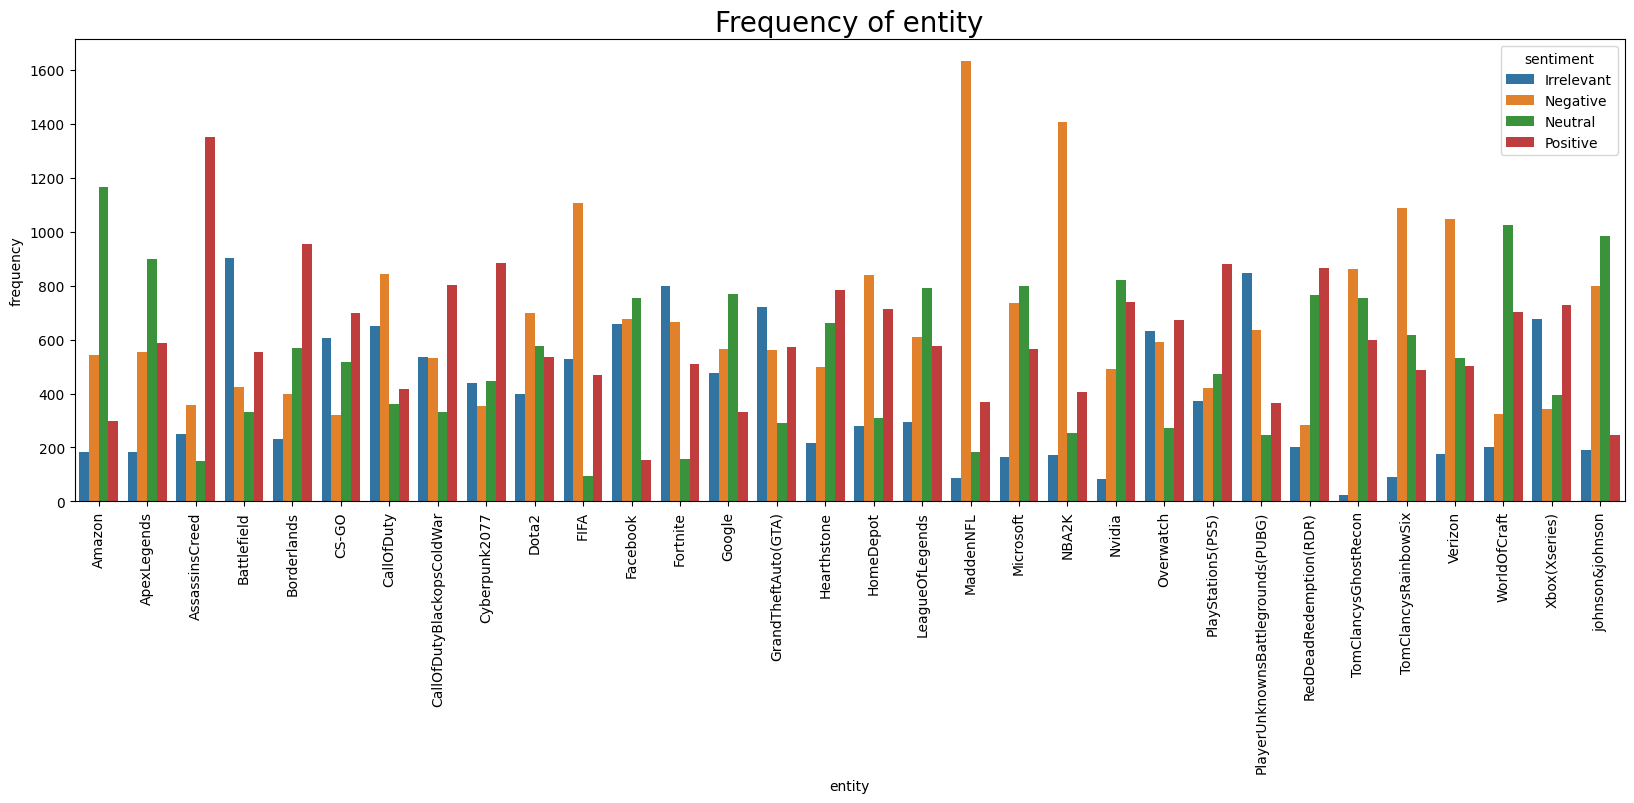

In [ ]:
entity_frequency = removed_df.groupby(["sentiment","entity"]).size().reset_index()
#.size() Counts the number of rows (frequency) in each group combination (sentiment, entity).
entity_frequency.rename(columns={0: 'frequency'}, inplace=True)

plt.figure(figsize=(20,6))
plt.xticks(rotation=90)
sns.barplot(data=entity_frequency,x="entity",y="frequency",hue="sentiment").set_title("Frequency of entity", fontsize=20)

## Sentiment Ratio Analysis per Entity
The ratio of positive, negative, and neutral sentiment is calculated for each entity, providing an overview of how public opinion is divided toward that entity. There are no irrelevant or neutral sentiments, as they are unrelated to content. Therefore, only explicit positive versus negative opinions are sought.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of sentiments per entity
sentiment_counts = df.groupby(['entity', 'sentiment']).size().unstack(fill_value=0)

# Calculate Positive and Negative ratio
sentiment_counts['pos_ratio'] = sentiment_counts['Positive'] / (
    sentiment_counts['Positive'] + sentiment_counts['Negative'] + 1e-5)  # Avoid zero division
sentiment_counts['neg_ratio'] = sentiment_counts['Negative'] / (
    sentiment_counts['Positive'] + sentiment_counts['Negative'] + 1e-5)

# Sort by positive ratio (optional)
sentiment_counts_sorted = sentiment_counts.sort_values('pos_ratio', ascending=False)

### Heatmap of sentiment ratios per entity
Heatmap visualization is used to more clearly compare sentiment ratios between entities, so that patterns of sentiment dominance can be seen.

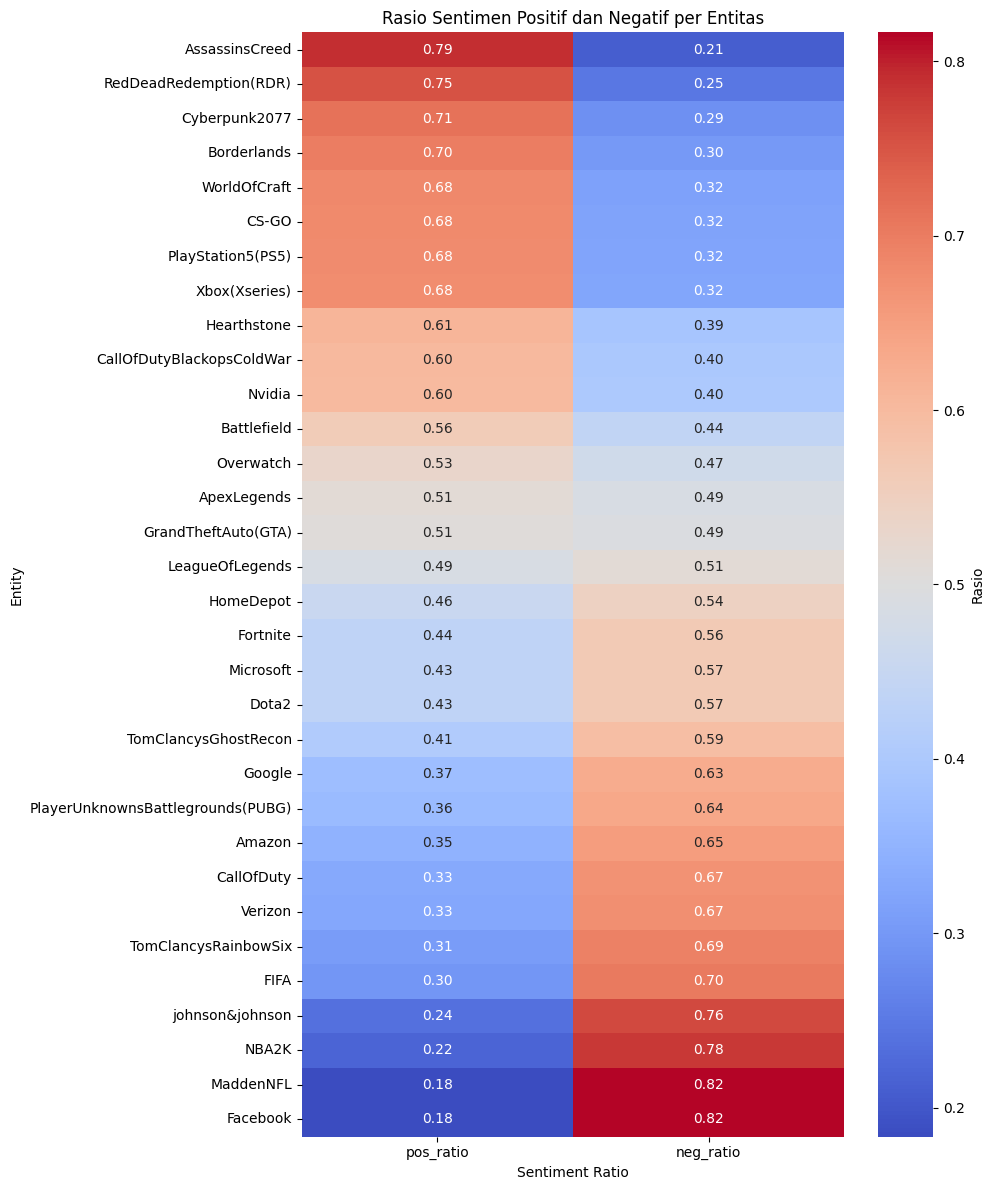

In [ ]:
# Take only ratio columns
ratios = sentiment_counts_sorted[['pos_ratio', 'neg_ratio']]

# Plotting heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(ratios, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Ratio'})
plt.title("Positive and Negative Sentiment Ratio per Entity")
plt.ylabel("Entity")
plt.xlabel("Sentiment Ratio")
plt.tight_layout()
plt.show()

### Net sentiment score per entity
The net score is calculated as the difference between positive and negative sentiment for each entity. This metric helps to concisely measure sentiment trends.

In [ ]:
sentiment_counts['net_score'] = sentiment_counts['Positive'] - sentiment_counts['Negative']
sentiment_counts['net_score'].sort_values()
#Positive value = more positive tweets.
#Negative value = more negative tweets.

,net_score
entity,
MaddenNFL,-1284
NBA2K,-1038
FIFA,-652
TomClancysRainbowSix,-615
johnson&johnson,-558
Verizon,-552
Facebook,-532
CallOfDuty,-433
PlayerUnknownsBattlegrounds(PUBG),-277


### Proportion of positive vs. negative sentiment per entity
This proportion analysis is used to compare the difference between positive and negative sentiment towards each entity.

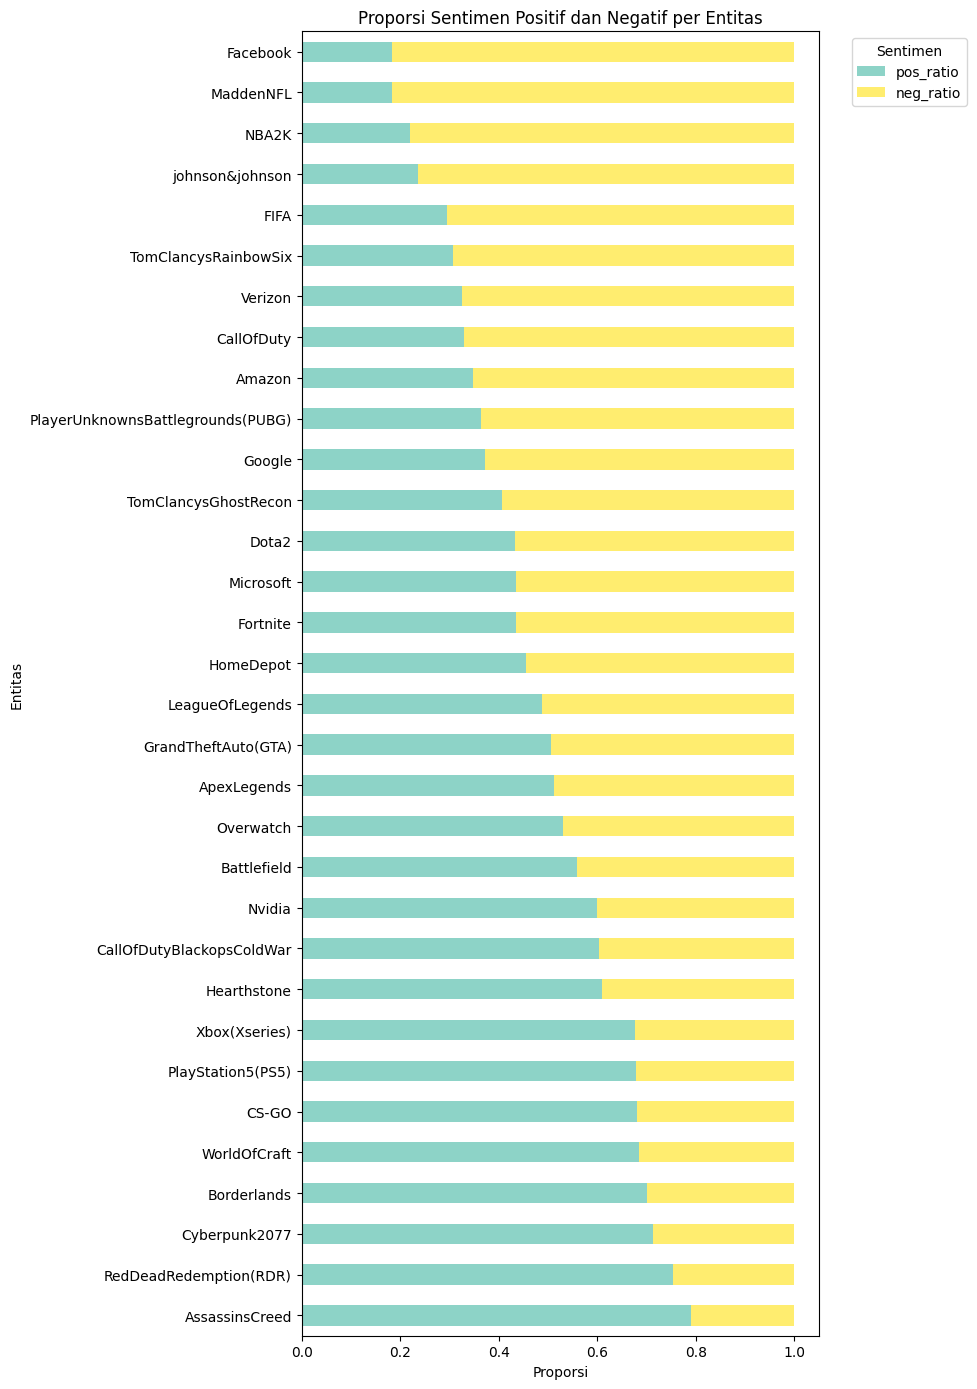

In [ ]:
# Calculate the proportions of all
sentiments_prop = ratios.div(ratios.sum(axis=1), axis=0).sort_values('pos_ratio', ascending=False)

# Visualization of proportions (stacked bar chart)
sentiments_prop.plot(kind='barh', stacked=True, figsize=(10, 14), colormap='Set3')
plt.title("Proportion of Positive and Negative Sentiment per Entity")
plt.xlabel("Proportion")
plt.ylabel("Entity")
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Proportion of all entities if neutral and irrelevant are included
The sentiment proportion is recalculated by including the neutral and irrelevant categories, providing a more complete picture of sentiment distribution.

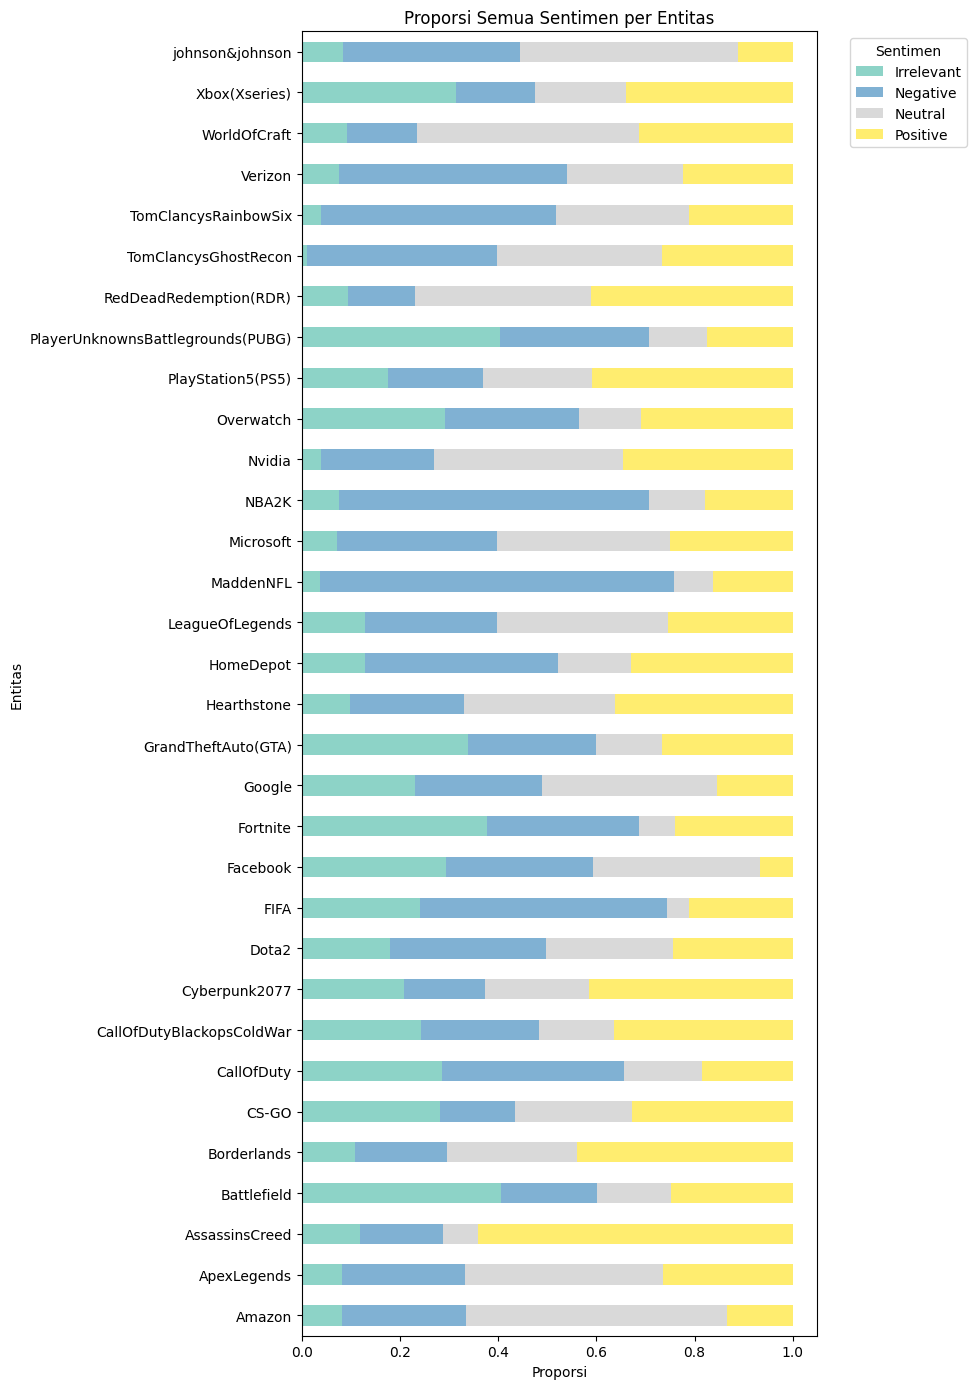

In [ ]:
# Calculate all categories
all_sentiments = df.groupby(['entity', 'sentiment']).size().unstack(fill_value=0)

# Calculate the proportion of all
all_sentiments_prop = all_sentiments.div(all_sentiments.sum(axis=1), axis=0)

# Sort alphabetically by entities
all_sentiments_prop = all_sentiments_prop.sort_index()

# Visualize proportions (stacked bar chart)
all_sentiments_prop.plot(kind='barh', stacked=True, figsize=(10, 14), colormap='Set3')
plt.title("Proportion of All Sentiments per Entity")
plt.xlabel("Proportion")
plt.ylabel("Entity")
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#.unstack(): Convert the sentiment values from the index to a new column, making the results easier to read.
#fill_value=0: If an entity doesn't have a sentiment, fill it with 0 (not NaN).
#.div(..., axis=0): Divide each row by its total,
#so the result is the proportion per sentiment (all columns have values between 0–1 and a total of 1).
#bbox_to_anchor=(1.05, 1): Position the legend to the right of the graph (to avoid overlapping).

# Data Splitting

### Why is the entity placed at the front?

| Reason | Explanation |
| --------------------- | -------------------------------------------- |
| Entity context | Informs the model of the main topic |
| Natural linguistic patterns | Mimics human reading (subject first) |
| Simple model | More sensitive to word order |
| No additional features | Can avoid separate entity features |

In [ ]:
#Split training data and validation data
x_train = df["entity"] + " " + df["tweet content"]
y_train = df["sentiment"]
x_test = df_val["entity"] + " " + df_val["tweet content"]
y_test = df_val["sentiment"]

In [ ]:
x_train.head()

,0
0,Borderlands im getting on borderlands and i wi...
1,Borderlands I am coming to the borders and I w...
2,Borderlands im getting on borderlands and i wi...
3,Borderlands im coming on borderlands and i wil...
4,Borderlands im getting on borderlands 2 and i ...


# Text Preprocessing
This stage involves a series of processes such as case folding, tokenization, stopword removal, and stemming/lemmatization. The goal is to prepare the text for use in a sentiment analysis model.

In [ ]:
# function converts pos_tag to wordnet_pos
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'): # If the tag starts with 'J', it's an adjective, e.g., JJ, JJR, JJS.
        return wordnet.ADJ # Returned in WordNet-compliant format: wordnet.ADJ
    elif pos_tag.startswith('V'): # If the tag starts with 'V', it's a verb, e.g., VB, VBD, VBG, etc.
        return wordnet.VERB # Returned as wordnet.VERB.
    elif pos_tag.startswith('N'): # If the tag starts with 'N', it's a noun, e.g., NN, NNS, etc.
        return wordnet.NOUN # Returned as wordnet.NOUN.
    elif pos_tag.startswith('R'): #If the tag starts with 'R', it's an adverb, for example, RB, RBR, RBS.
        return wordnet.ADV #Returned as wordnet.ADV.
    else:
        return None
#If the tag doesn't fall into that category (e.g., symbol, preposition, conjunction, etc.), then None is returned.
#This is important because the WordNet Lemmatizer doesn't recognize tags other than NOUN, VERB, ADJ, and ADV,
#so None defaults to NOUN.

In [ ]:
def text_preprocessing(text):

    #tokenization
    text_tokenize = word_tokenize(text)

    #split text and entities
    entity = text_tokenize[0]
    text_content = text_tokenize[1:]

    #post tagging
    text_pos = pos_tag(text_content)

    #remove stopwords and punctuation
    remove_words = set(list(string.punctuation) + stopwords.words('english'))
    text_remove = [(word,pos) for (word,pos) in text_pos if word not in remove_words]

    #lemmatization
    word_lem = WordNetLemmatizer()
    text_lem = [(word_lem.lemmatize(word,pos=get_wordnet_pos(pos)),pos) if get_wordnet_pos(pos) != None
                 else (word_lem.lemmatize(word),pos) for (word,pos) in text_remove]

    #combine text and entities
    text_lem.append((entity,))

    return text_lem

In [ ]:
#test text_preprocessing
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Untuk lemmatization

example_text = "Overwatch Overwatch is a wonderful game, even after so many years."
print("Original sentence: ", example_text)
print("After text_preprocessing: ", text_preprocessing(example_text))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Original sentence:  Overwatch Overwatch is a wonderful game, even after so many years.
After text_preprocessing:  [('Overwatch', 'NN'), ('wonderful', 'JJ'), ('game', 'NN'), ('even', 'RB'), ('many', 'JJ'), ('year', 'NNS'), ('Overwatch',)]


The words "is," "after," and "," (punctuation) are removed because they are stopwords.

"years" is changed to "year" due to lemmatization.

"Overwatch" appears twice: first as a token resulting from POS tagging, and finally as an entity (returned at the end of the function).

| Token | POS Tag | Lemma (base form) | POS Meaning |
| --------- | ------- | -------------------- | ------------------------------------------------------------------ |
| Overwatch | NN | Overwatch | Noun → game name |
| wonderful | JJ | wonderful | Adjective |
| game | NN | game | Noun |
| even | RB | even | Adverb |
| many | JJ | many | Adjective |
| year | NNS | year | Noun plural → reduced to base form "year" |
| Overwatch | | | This is an entity that is reinserted at the end (without POS) |

### Combining text_preprocessing, CountVectorizer, and TfidfTransformer into a pipeline
A pipeline was created to combine text preprocessing with numeric representation using `CountVectorizer` and `TfidfTransformer`. This approach ensures a more efficient and structured data transformation process when used in machine learning models.

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_preprocessing)),
    ('tfidf', TfidfTransformer())
])

### Implementation of pipeline to x_train and x_test

In [ ]:
x_train_processed = pipeline.fit_transform(x_train)
x_test_processed = pipeline.transform(x_test)

| Steps | Functions |
| -------------------- | ------------------------------------------------------------ |
| `text_preprocessing` | Cleaning text: tokenization, stopword removal, lemmatization |
| `CountVectorizer` | Converting text into a bag-of-words matrix |
| `TfidfTransformer` | Assigning importance weights to words based on frequency |
| `Pipeline` | Automatically combining all steps |

Example Results (illustration)

If x_train contains:\
["I love Overwatch", "Overwatch is great"]

After preprocessing:\
[['love', 'Overwatch'], ['Overwatch', 'great']]

After BOW:
| Word       | Doc1 | Doc2 |
|------------|------|------|
| love       | 1    | 0    |
| Overwatch  | 1    | 1    |
| great      | 0    | 1    |

After TF-IDF: → numeric matrix with weights

# Models

In [ ]:
classifier_used = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
]

In [ ]:
classifier_accuracy=[]

for classifier in classifier_used:

    fit = classifier.fit(x_train_processed, y_train)
    predict = fit.predict(x_test_processed)
    trainset_predict = fit.predict(x_train_processed)

    accuracy = accuracy_score(predict,y_test)
    trainset_accuracy = accuracy_score(trainset_predict,y_train)

    classifier_accuracy.append([classifier.__class__.__name__,accuracy,trainset_accuracy])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
classifier_result = pd.DataFrame(classifier_accuracy,columns=["classifier",
                                                              "accuracy","accuracy on trainset"]).sort_values(
                                                                  by='accuracy',ascending=False)
classifier_result

,classifier,accuracy,accuracy on trainset
1,KNeighborsClassifier,0.990,0.964317
3,RandomForestClassifier,0.970,0.987979
0,LogisticRegression,0.930,0.885037
2,DecisionTreeClassifier,0.912,0.987979


KNeighborsClassifier obtained the highest accuracy of 0.990.

In [ ]:
# Import additional models and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Model list
classifier_used = [
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    SVC(),
    MultinomialNB(),
    MLPClassifier(max_iter=500),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss')
]

In [ ]:
# Save the evaluation results
classifier_accuracy = []

for classifier in classifier_used:
    fit = classifier.fit(x_train_processed, y_train)
    predict = fit.predict(x_test_processed)
    trainset_predict = fit.predict(x_train_processed)

    accuracy = accuracy_score(y_test, predict)
    trainset_accuracy = accuracy_score(y_train, trainset_predict)
    precision = precision_score(y_test, predict, average='weighted', zero_division=0)
    recall = recall_score(y_test, predict, average='weighted', zero_division=0)
    f1 = f1_score(y_test, predict, average='weighted', zero_division=0)

    classifier_accuracy.append([
        classifier.__class__.__name__,
        round(accuracy, 3),
        round(trainset_accuracy, 3),
        round(precision, 3),
        round(recall, 3),
        round(f1, 3)
    ])

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got ['Irrelevant' 'Negative' 'Neutral' 'Positive']

Because XGBoost Error and MLP are very long processes, a separate code will be created for XGBoost.

In [ ]:
# --- Label Encoding ---
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# --- XGBoost model initialization ---
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
fit = xgb.fit(x_train_processed, y_train_encoded)

# --- Prediction ---
predict = fit.predict(x_test_processed)
trainset_predict = fit.predict(x_train_processed)

# --- Evaluation ---
accuracy = accuracy_score(y_test_encoded, predict)
trainset_accuracy = accuracy_score(y_train_encoded, trainset_predict)
precision = precision_score(y_test_encoded, predict, average='weighted', zero_division=0)
recall = recall_score(y_test_encoded, predict, average='weighted', zero_division=0)
f1 = f1_score(y_test_encoded, predict, average='weighted', zero_division=0)

# --- Save the evaluation results to the list ---
classifier_accuracy.append([
    xgb.__class__.__name__,
    round(accuracy, 3),
    round(trainset_accuracy, 3),
    round(precision, 3),
    round(recall, 3),
    round(f1, 3)
])

In [ ]:
# Create a DataFrame of the results
import pandas as pd
classifier_result = pd.DataFrame(
    classifier_accuracy,
    columns=["Classifier", "Accuracy", "Train Accuracy", "Precision", "Recall", "F1 Score"]
).sort_values(by="Accuracy", ascending=False)

In [ ]:
classifier_result

,Classifier,Accuracy,Train Accuracy,Precision,Recall,F1 Score
1,KNeighborsClassifier,0.990,0.964,0.990,0.990,0.990
6,SVC,0.983,0.982,0.983,0.983,0.983
3,RandomForestClassifier,0.977,0.988,0.977,0.977,0.977
8,MLPClassifier,0.975,0.987,0.975,0.975,0.975
0,LogisticRegression,0.947,0.904,0.947,0.947,0.947
2,DecisionTreeClassifier,0.908,0.988,0.908,0.908,0.908
7,MultinomialNB,0.839,0.814,0.864,0.839,0.838
9,XGBClassifier,0.753,0.721,0.758,0.753,0.752
4,GradientBoostingClassifier,0.574,0.558,0.585,0.574,0.572
5,AdaBoostClassifier,0.345,0.351,0.613,0.345,0.268


## Interpretation

- Reasonable models:
    * Logistic Regression (94.7%) – reasonable results for NLP with TF-IDF.
    * Naive Bayes (83.9%) – reasonable as a baseline text model.
    * Decision Tree (90.8% test, 98.8% train) – overfitting, but normal for a decision tree.
- Suspicious/overfitting models:
    * KNN (99%) – *too good*, suspect data leakage.
    * SVC (98.3%), Random Forest (97.7%), MLP (97.5%) – very high, suspect data leakage or entities dominating the predictions.
- Odd/bad models:
    * XGBoost (75%) – low performance, possibly due to mismatched TF-IDF inputs.
    * GradientBoosting (57%) & AdaBoost (34%) – poor performance, possibly due to incorrect string labels or configuration.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Label encoding for y_train and y_test
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
label_names = label_encoder.classes_

## More about Logistic Regression

In [ ]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train_processed, y_train_encoded)
y_pred = logreg.predict(x_test_processed)

In [ ]:
print("📋 Classification Report: Logistic Regression")
print(classification_report(label_encoder.inverse_transform(y_test_encoded),
                            label_encoder.inverse_transform(y_pred)))

📋 Classification Report: Logistic Regression
              precision    recall  f1-score   support

  Irrelevant       0.95      0.92      0.94       172
    Negative       0.94      0.97      0.96       266
     Neutral       0.96      0.93      0.94       285
    Positive       0.94      0.95      0.95       277

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



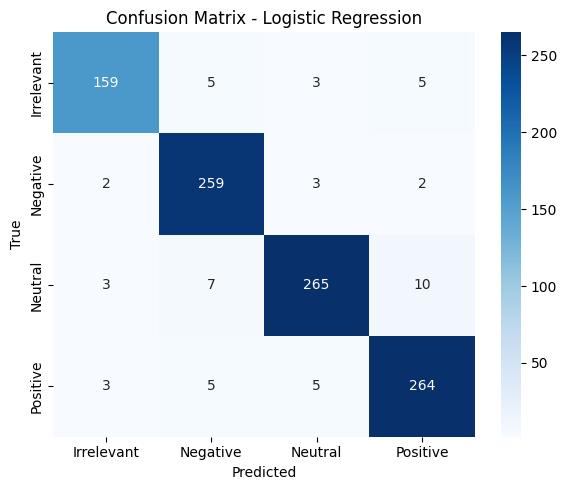

In [ ]:
cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

- Interpretation of Results:
    * The majority of predictions are on target, with high diagonal values (159, 259, 265, 264).
    * The number of (off-diagonal) errors is small (only a few units), indicating that the model does not confuse much between classes.
    * The model is not overly biased toward one class — all classes receive predictions with sufficient precision and recall.
- Why is 95% Accuracy Reasonable?
    * The distribution between classes is likely quite balanced, or not too skewed, so the model does not learn bias.
    * Good preprocessing (such as lemmatization, tokenization, vectorizer/embedding) helps the model focus on meaningful features.
    * The number of features and text representations used in x_train_processed are likely quite robust (TFIDF, embeddings, etc.).
    * The large data size (~71k rows) also provides sufficient stable learning for Logistic Regression.

## More About Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train_processed, y_train_encoded)
y_pred = rf.predict(x_test_processed)

In [ ]:
print("📋 Classification Report: Random Forest")
print(classification_report(label_encoder.inverse_transform(y_test_encoded),
                            label_encoder.inverse_transform(y_pred)))

📋 Classification Report: Random Forest
              precision    recall  f1-score   support

  Irrelevant       1.00      0.99      0.99       172
    Negative       0.98      0.97      0.98       266
     Neutral       0.96      0.98      0.97       285
    Positive       0.97      0.96      0.97       277

    accuracy                           0.97      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.97      0.97      0.97      1000



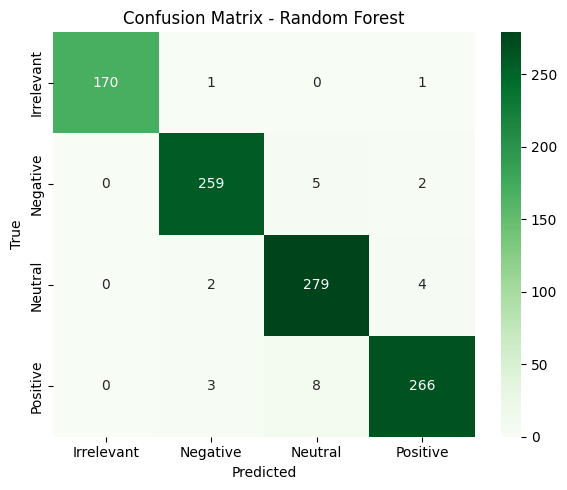

In [ ]:
cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

- Interpretation of Results:
    * 97% accuracy seems reasonable and realistic for a Random Forest model on large data sets with good feature representation.
    * The Irrelevant and Neutral classes are predicted very accurately (only 1–2 errors).
    * No class is dominated by errors (none are overpredicted or underpredicted).
- Why Does This High Accuracy Make Sense?
    * Random Forest is very powerful for tabular classification if the features are representative (TF-IDF or other text vectors).
    * Your data is large (71k+), allowing Random Forest to "learn" steadily.
    * Good preprocessing (lemmatization, stopword removal, etc.) reduces noise in the input.

## More about KNN

In [ ]:
knn = KNeighborsClassifier()
knn.fit(x_train_processed, y_train_encoded)
y_pred = knn.predict(x_test_processed)

In [ ]:
print("📋 Classification Report: KNN")
print(classification_report(label_encoder.inverse_transform(y_test_encoded),
                            label_encoder.inverse_transform(y_pred)))

📋 Classification Report: KNN
              precision    recall  f1-score   support

  Irrelevant       1.00      1.00      1.00       172
    Negative       0.98      0.99      0.99       266
     Neutral       1.00      0.98      0.99       285
    Positive       0.98      0.99      0.99       277

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



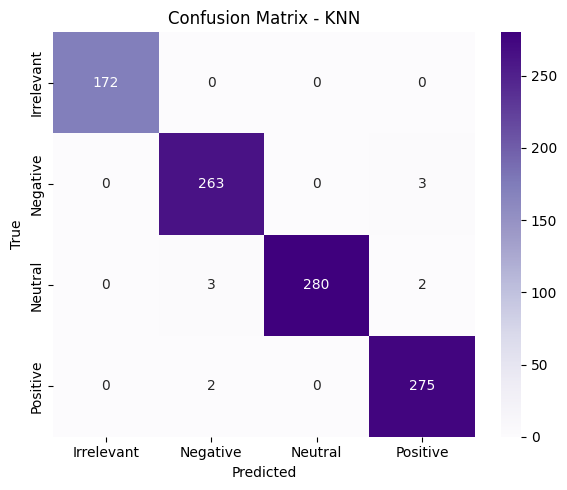

In [ ]:
cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

- Interpretation of Results
    * 99% accuracy seems too perfect — for a model as simple as KNN, this is somewhat suspicious.
    * Almost all predictions are on the main diagonal → meaning the predictions match the labels exactly.
    * Error is very minimal: only 10 errors out of hundreds of predictions.

- 99% may be reasonable because:
    * The numerical features are highly representative, such as the highly structured embedding vectors.
    * The dataset is very clean and free of noise.
    * The classes are very distant in vector space (e.g., TF-IDF or PCA are good).
    * KNN uses a small k value (k = 1 or 3), which is suitable for highly clustered data distributions.

## More about Decision Tree

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(x_train_processed, y_train_encoded)
y_pred = dt.predict(x_test_processed)

In [ ]:
print("📋 Classification Report: Decision Tree")
print(classification_report(label_encoder.inverse_transform(y_test_encoded),
                            label_encoder.inverse_transform(y_pred)))

📋 Classification Report: Decision Tree
              precision    recall  f1-score   support

  Irrelevant       0.94      0.90      0.92       172
    Negative       0.90      0.93      0.92       266
     Neutral       0.89      0.90      0.90       285
    Positive       0.93      0.91      0.92       277

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



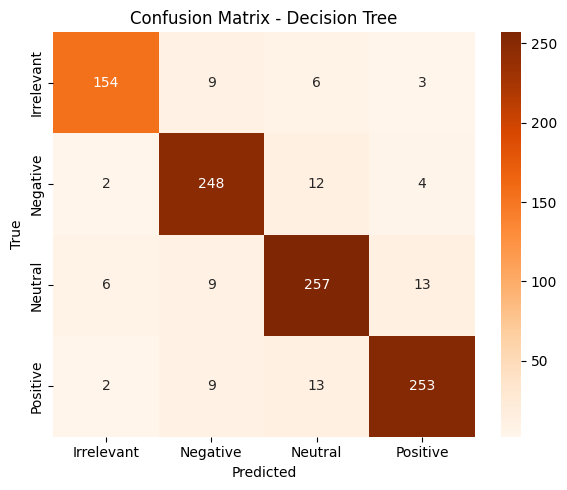

In [ ]:
cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

- Why It Makes Sense:
    * Decision Trees tend to overfit, but are still quite capable of capturing text patterns if the features (TF-IDF) are strong and there's a lot of data.
    * Having >70,000 training data points (in the form of x_train_processed), so the model can learn many specific patterns.
    * Data preprocessing and input labels are clean (no mislabeling, encoding, etc.).
    * The confusion matrix does not show extreme bias towards any particular class.

This Twitter sentiment analysis successfully uncovered public perceptions of major entities such as Facebook, Amazon, Microsoft, CS-GO, and Google. Through a comprehensive data cleaning process, visual exploration, and sentiment metric calculations, a clear picture of the proportion of positive and negative opinions for each entity was obtained.

The modeling phase, which tested various machine learning algorithms, provided an informative performance comparison. The results showed that different algorithmic approaches can produce significant variations in accuracy and generalizability. These findings emphasize the importance of selecting the right model based on the data characteristics and analysis objectives.

Overall, this project not only provides descriptive insights from social media data but also builds the foundation for a sentiment prediction system that can be adapted to real-world scenarios, such as brand reputation monitoring or public opinion analysis on specific issues.

# Thank You